# NLP Classification Modeling

> **NOTE** Many of the cells are commented out since if they were run they may take hours to complete.  I have left cells relating to the final selected model active, so if all cells are run as is, this notebook could take 30 minutes or longer to complete.

### Import Libraries

In [86]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, 
                             RocCurveDisplay)

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

### Read Data

In [87]:
df = pd.read_csv('../data/reddit_cleaned.csv')

In [88]:
df.head(3)

,subreddit,author,num_comments,selftext,title,text
0,playstation,Blix404,8,PlayStation. Why\n1st of PlayStation has been out since 2013 and you guys close to releasing the PS5 so why tf do you now all of a sudden start recording our party conversations.\n2nd of I ain’t getting banned just cause some snowflake in my party chat felt the need to snitch on me. Fuck outta here with that BS.\n\n3rd. Xbox Doesn’t do that so why do you feel the need to do that you dickheads....,PARTY CHAT BEING RECORDED,party chat be record why 1st of have be out since and you guy close to release the 5 so why tf do you now all of a sudden start record our party conversation 2nd of I ai not getting ban just cause some snowflake in my party chat feel the need to snitch on I fuck outta here with that bs 3rd do not do that so why do you feel the need to do that you dickhead just prove to be more and more of ...
1,playstation,ImmaPoodle,0,"So watch dogs legion is coming out soon and with interesting mechanics and ray tracing I think it might be what people thought watch dogs 2 would be... a predecessor to GTA 5, ok let's be honest watch dogs 2 was an amazing game but it lacked that feeling that GTA had as well as the already large player base.\n\nBut this time with already tons of preordered copies of watch dogs legion in circle...",Ubisoft vs Rockstar,ubisoft vs rockstar so watch dog legion be come out soon and with interesting mechanic and ray trace I think it might be what people think watch dog would be a predecessor to gta ok let us be honest watch dog be an amazing game but it lack that feeling that gta have as well as the already large player base but this time with already ton of preordere copy of watch dog legion in circle and ro...
2,playstation,georgios82,6,"So guys let me get this straight. If you want to temporarily invite someone to your party, then they will be automatically (permanently) added to the chat as well? Not only that but from my understanding they will also be able to see all older discussions that took place in that group? Am I missing something here? Is there a way to avoid this?",Question regarding the recent party changes,question regard the recent party change so guy let I get this straight if you want to temporarily invite someone to your party then they will be automatically permanently add to the chat as well not only that but from my understanding they will also be able to see all old discussion that take place in that group be I miss something here be there a way to avoid this


Transform the subreddit feature to binary for use in our classification modeling

In [89]:
df['subreddit'].value_counts(normalize=True).mul(100).round(2)

playstation    52.37
xbox           47.63
Name: subreddit, dtype: float64

In [90]:
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'playstation' else 0)

In [91]:
df['subreddit'].value_counts(normalize=True).mul(100).round(2)

1    52.37
0    47.63
Name: subreddit, dtype: float64

1 = Playstation<br>
0 = Xbox

In [92]:
# rename as target since that is easier for me to remember
df.rename({'subreddit': 'target'}, axis=1, inplace=True)

### Configure X, y, and split

In [93]:
X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=415,
                                                    stratify=y)

In [94]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13998,), (4666,), (13998,), (4666,))

## Modeling

Overall, I'd like to look at a few different models by first checking their scores with default settings in both CountVectorizer and TfidfVectorizer processing with the default settings, and then an additional GridSearch for each model to try and identify which classifier I would like to tune and select for production.  

I'll start by establishing the baseline, and then work through various models to try and identify which one should be tuned for the best predictive power. 

> Note: I have commented out some of the code that requires long periods of time to run, such as the Grid Searches, in order to be able to run this entire notebook relatively quickly upon opening.

### Baseline

To calculate our baseline, since we're classifying, we'll look at the majority class of the y of the data.  For our model to provide value, it will need to do better than just predicting the majority class each time.

In [95]:
y.value_counts(normalize=True).mul(100).round(2)

1    52.37
0    47.63
Name: target, dtype: float64

Compare the train and test split stratification

In [96]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

1    0.523718
0    0.476282
Name: target, dtype: float64
1    0.523789
0    0.476211
Name: target, dtype: float64


We'll need our models to perform better than 52.4% accuracy in order to be better than just always predicting the majority class (1 = playstation).

### Decision Tree

#### Configure Decision Tree Pipelines

DecisionTreeClassifier with CountVectorizer

In [97]:
dtc_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('dtc', DecisionTreeClassifier())
])

In [98]:
# fit with default settings for CountVectorizer and DeciscionTree
dtc_cv.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('dtc', DecisionTreeClassifier())])

In [99]:
# score with default settings for CountVectorizer and DeciscionTree
dtc_cv.score(X_train, y_train), dtc_cv.score(X_test, y_test)

(0.9997856836690956, 0.7130304329189884)

DecisionTree Classifier with TfidfVectorizer

In [100]:
dtc_tdf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('dtc', DecisionTreeClassifier())
])

In [101]:
# fit with default settings for TfidfVectorizer and DeciscionTree
dtc_tdf.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()), ('dtc', DecisionTreeClassifier())])

In [102]:
# score with default settings for TfidfVectorizer and DeciscionTree
dtc_tdf.score(X_train, y_train), dtc_tdf.score(X_test, y_test)

(0.9997856836690956, 0.6954564937848264)

As we can expect with DecisionTree, we're seeing the model overfit, which can tend to happen, and the model isn't generalizing to the test data very will.  In this case, it appears that the CountVectorizer is performing a little bit better than the TfidfVectorizer, at least when both have their default settings.  The CV version is about 1% more accurate.

#### GridSearch

GridSearch to use coarse hyperparameter searching, instead of default parameters, in order to find and select the best model for tuning.

GridSearching both CountVectorizer and TfidfVectorizer

In [103]:
# set two
cv_dtc_params = {
    'cv__stop_words': ['english'],
    'cv__max_df': [0.8, 0.85, 0.90],
    'cv__min_df': [6, 10, 15],
    'cv__ngram_range': [(1,2), (1,3)],
    'cv__max_features': [5_000, 10_000, 15_000],
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__max_depth': [25, 50, 100],
    'dtc__min_samples_split': [10, 50, 100],
    'dtc__max_features': [None, 'sqrt']
}

## set one
# cv_dtc_params = {
#     'cv__stop_words': [None, 'english'],
#     'cv__max_df': [0.85, 0.95],
#     'cv__min_df': [4, 5, 6],
#     'cv__ngram_range': [(1,1), (1,2), (2,2)],
#     'cv__max_features': [1_000, 5_000, 10_000],
#     'dtc__criterion': ['gini', 'entropy'],
#     'dtc__max_depth': [3, 10, 20],
#     'dtc__min_samples_split': [2, 4, 10],
#     'dtc__max_features': [None, 'sqrt', 'log2']
# }

In [104]:
# # configure GridSearch
# gs_dtc_cv = GridSearchCV(dtc_cv, cv_dtc_params, n_jobs=-1, verbose=1)

# # fit with training data
# gs_dtc_cv.fit(X_train, y_train)

# # output the best params after GridSearch is complete
# gs_dtc_cv.best_params_

In [105]:
# # get train and test scores from the model fit with the parameters from 
# # GridSearch
# gs_dtc_cv.score(X_train, y_train), gs_dtc_cv.score(X_test, y_test)

Decision Tree w/CountVectorizer Results
- set two (0.8478354050578654, 0.744320617231033)
    - 'cv__max_df': 0.85,
    - 'cv__max_features': 10000,
    - 'cv__min_df': 6,
    - 'cv__ngram_range': (1, 3),
    - 'cv__stop_words': 'english',
    - 'dtc__criterion': 'entropy',
    - 'dtc__max_depth': 100,
    - 'dtc__max_features': None,
    - 'dtc__min_samples_split': 100

- set one (0.769609944277754, 0.7368195456493785)
    - 'cv__max_df': 0.85,
    - 'cv__max_features': 10000,
    - 'cv__min_df': 6,
    - 'cv__ngram_range': (1, 2),
    - 'cv__stop_words': None,
    - 'dtc__criterion': 'entropy',
    - 'dtc__max_depth': 20,
    - 'dtc__max_features': None,
    - 'dtc__min_samples_split': 10

In [106]:
# set two
tdf_dtc_params = {
    'tf__stop_words': ['english'],
    'tf__max_features': [4_000, 5_000, 7_500],
    'tf__min_df': [3, 4, 10],
    'tf__ngram_range': [(1,2), (1,3)],
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__max_depth': [25, 50, 75],
    'dtc__min_samples_split': [4, 5, 6],
    'dtc__max_features': [None, 'sqrt']
}

# # set one
# tdf_dtc_params = {
#     'tf__stop_words': ['english'],
#     'tf__max_features': [1_000, 5_000, 10_000],
#     'tf__min_df': [1, 3, 5],
#     'tf__ngram_range': [(1,2), (1,3)],
#     'dtc__criterion': ['gini', 'entropy'],
#     'dtc__max_depth': [3, 10, 20],
#     'dtc__min_samples_split': [2, 5, 10],
#     'dtc__max_features': [None, 'sqrt']
# }

In [107]:
# # configure GridSearch
# gs_dtc_tf = GridSearchCV(dtc_tdf, tdf_dtc_params, n_jobs=-1, verbose=1)

# # fit with training data
# gs_dtc_tf.fit(X_train, y_train)

# # output the best params after GridSearch is complete
# gs_dtc_tf.best_params_

In [108]:
# # get train and test scores from the model fit with the parameters from 
# # GridSearch
# gs_dtc_tf.score(X_train, y_train), gs_dtc_tf.score(X_test, y_test)

Decision Tree w/TfidfVectorizer Results
- set two (0.9172024574939277, 0.7353193313330476)
    - 'dtc__criterion': 'gini',
    - 'dtc__max_depth': 75,
    - 'dtc__max_features': None,
    - 'dtc__min_samples_split': 5,
    - 'tf__max_features': 7500,
    - 'tf__min_df': 3,
    - 'tf__ngram_range': (1, 2),
    - 'tf__stop_words': 'english'

- set one  (0.7657522503214745, 0.7297471067295328)
    - 'dtc__criterion': 'gini',
    - 'dtc__max_depth': 20,
    - 'dtc__max_features': None,
    - 'dtc__min_samples_split': 5,
    - 'tf__max_features': 5000,
    - 'tf__min_df': 3,
    - 'tf__ngram_range': (1, 3),
    - 'tf__stop_words': 'english'

#### Best Decision Tree

The best performing Decision Tree:
- Train: 0.845
- Test:  0.744

Params
- 'cv__max_df': 0.85,
- 'cv__max_features': 10000,
- 'cv__min_df': 6,
- 'cv__ngram_range': (1, 3),
- 'cv__stop_words': 'english',
- 'dtc__criterion': 'entropy',
- 'dtc__max_depth': 100,
- 'dtc__max_features': None,
- 'dtc__min_samples_split': 100

These scores are certainly improved from the baseline, but not much of an improvement from the default settings with each vectorizer paired with a Decision Tree classifier. The overfit that appeared on the train score from the default settings appears to be reduced, probably in part to limiting how deep the decision tree was able to go, especially on the first set of grid search parameters.  

The second grid search only improved the test scores marginally.  From these results, I think a different classifier will be more effective.  Let's move to a Random Forest classifier and see how that performs.

### Random Forest

#### Configure Random Forest Pipelines

Random Forest with CountVectorizer

In [109]:
rf_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [110]:
# fit with default parameters
rf_cv.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])

In [111]:
# score train and test data with default parameters
rf_cv.score(X_train, y_train), rf_cv.score(X_test, y_test)

(0.9997856836690956, 0.8004714959279897)

Random Forest with TfidfVectorizer

In [112]:
rf_tdf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [113]:
# fit with default parameters
rf_tdf.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()), ('rf', RandomForestClassifier())])

In [114]:
# score train and test data with default parameters
rf_tdf.score(X_train, y_train), rf_tdf.score(X_test, y_test)

(0.9997856836690956, 0.7918988426918131)

Even though these models are overfit on the training data, like we saw on Decision Tree classifier, the Random Forest classifier is generalizing to the test data fairly well.  With default settings this is an accuracy increase of 27 percentage points over the baseline and about 5 points better than the Decision Tree classifier.

#### GridSearch

GridSearch to use coarse hyperparameter searching, instead of default parameters, in order to find and select the best model for tuning.

For the first set of parameters in the grid search, I'll use same parameters that yielded the best results from the Decision Trees section for each vectorizer.

GridSearching both CountVectorizer and TfidfVectorizer

In [115]:
# set two
# cv_rf_params = {
#     'cv__stop_words': ['english'],
#     'cv__max_df': [0.85, 0.90],
#     'cv__min_df': [6],
#     'cv__ngram_range': [(1,2), (1,3)],
#     'cv__max_features': [5_000, 10_000],
#     'rf__n_estimators': [750, 1000, 1500],
#     'rf__max_depth': [200, 500],
#     'rf__max_samples': [0.85, 0.9],
#     'rf__max_features': ['sqrt', 'log2']
# }

# set one
# cv_rf_params = {
#     'cv__stop_words': ['english'],
#     'cv__max_df': [0.8, 0.85, 0.90],
#     'cv__min_df': [3, 6, 9],
#     'cv__ngram_range': [(1,2), (1,3)],
#     'cv__max_features': [5_000, 10_000, 15_000],
#     'rf__n_estimators': [100, 500, 750],
#     'rf__max_depth': [50, 100, 200],
#     'rf__max_samples': [0.8, 0.9, 1.0],
#     'rf__max_features': ['sqrt', 'log2']
# }

In [116]:
# # configure GridSearch
# gs_rf_cv = GridSearchCV(rf_cv, cv_rf_params, n_jobs=-1, verbose=1)

# # fit with training data
# gs_rf_cv.fit(X_train, y_train)

# # output the best params after GridSearch is complete
# gs_rf_cv.best_params_

In [117]:
# # get train and test scores from the model fit with the parameters from 
# # GridSearch
# gs_rf_cv.score(X_train, y_train), gs_rf_cv.score(X_test, y_test)

Random Forest w/CountVectorizer Results
- set two (0.9962137448206887, 0.8009001285897985)
    - 'cv__max_df': 0.9,
    - 'cv__max_features': 10000,
    - 'cv__min_df': 6,
    - 'cv__ngram_range': (1, 2),
    - 'cv__stop_words': 'english',
    - 'rf__max_depth': 500,
    - 'rf__max_features': 'log2',
    - 'rf__max_samples': 0.85,
    - 'rf__n_estimators': 1000

- set one (0.9864980711530219, 0.8015430775825118)
    - 'cv__max_df': 0.85,
    - 'cv__max_features': 5000,
    - 'cv__min_df': 6,
    - 'cv__ngram_range': (1, 2),
    - 'cv__stop_words': 'english',
    - 'rf__max_depth': 200,
    - 'rf__max_features': 'log2',
    - 'rf__max_samples': 0.9,
    - 'rf__n_estimators': 750

In [118]:
# set three
tdf_rf_params = {
    'tf__stop_words': ['english'],
    'tf__max_features': [10_000],
    'tf__min_df': [6],
    'tf__ngram_range': [(1,2)],
    'rf__n_estimators': [100, 500, 1000],
    'rf__max_depth': [50, 100, 200],
    'rf__max_samples': [0.8, 0.9, 1.0],
    'rf__max_features': ['sqrt', 'log2']
}

# set one
# tdf_rf_params = {
#     'tf__stop_words': ['english'],
#     'tf__max_features': [10_000, 15_000],
#     'tf__min_df': [3, 6, 9],
#     'tf__ngram_range': [(1,2), (1,3)]#,
#     # 'rf__n_estimators': [100, 500, 750],
#     # 'rf__max_depth': [50, 100, 200],
#     # 'rf__max_samples': [0.8, 0.9, 1.0],
#     # 'rf__max_features': ['sqrt', 'log2']
# }

In [119]:
# # configure GridSearch
# gs_rf_tdf = GridSearchCV(rf_tdf, tdf_rf_params, n_jobs=-1, verbose=1)

# # fit with training data
# gs_rf_tdf.fit(X_train, y_train)

# # output the best params after GridSearch is complete
# gs_rf_tdf.best_params_

In [120]:
# # get train and test scores from the model fit with the parameters from 
# # GridSearch
# gs_rf_tdf.score(X_train, y_train), gs_rf_tdf.score(X_test, y_test)

Random Forest w/TfidfVectorizer Results
- set three (0.9933561937419632, 0.7931847406772397)
     - 'rf__max_depth': 200,
     - 'rf__max_features': 'log2',
     - 'rf__max_samples': 1.0,
     - 'rf__n_estimators': 1000,
     - 'tf__max_features': 10000,
     - 'tf__min_df': 6,
     - 'tf__ngram_range': (1, 2),
     - 'tf__stop_words': 'english'

- set two (0.9993570510072868, 0.8002571795970853)
     - 'tf__max_features': 10000,
     - 'tf__min_df': 6,
     - 'tf__ngram_range': (1, 2),
     - 'tf__stop_words': 'english'
    
- set one few tf params (0.9993570510072868, 0.7916845263609087)
     - 'tf__max_features': 10000, 'tf__min_df': 6, 'tf__stop_words': 'english'

#### Best Random Forest

The best performing Random Forest:
- Train: .986
- Test:  .802

Params
- 'cv__max_df': 0.85,
- 'cv__max_features': 5000,
- 'cv__min_df': 6,
- 'cv__ngram_range': (1, 2),
- 'cv__stop_words': 'english',
- 'rf__max_depth': 200,
- 'rf__max_features': 'log2',
- 'rf__max_samples': 0.9,
- 'rf__n_estimators': 750

The Random Forest models, appear to be the highest performing so far.  Even though these models are showing they are overfit to the training data, they are still generalizing to the test data fairly well. It is likely a front runner for choice as the production model for this project, but I will wait until I finish with the modeling before making that decision.

### k Nearest Neighbors

Now that I've evaluated two different tree-based models, let's look at kNN and see how it performs. With kNN the data will need to be scaled as well, so I'll configure a pipeline.

#### Configure Random k Nearest Neighors Pipelines

kNN with CountVectorizer

In [121]:
knn_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

In [122]:
# fit with default parameters
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('ss', StandardScaler(with_mean=False)),
                ('knn', KNeighborsClassifier())])

In [123]:
# score train and test with default parameters
knn_pipe.score(X_train, y_train), knn_pipe.score(X_test, y_test)

(0.735533647663952, 0.6050150021431633)

kNN with TfidfVectorizer

In [124]:
knn_pipe_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

In [125]:
# fit with default parameters
knn_pipe_tf.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('ss', StandardScaler(with_mean=False)),
                ('knn', KNeighborsClassifier())])

In [126]:
# score train and test with default parameters
knn_pipe_tf.score(X_train, y_train), knn_pipe_tf.score(X_test, y_test)

(0.8129732818974139, 0.6140162880411487)

#### GridSearch

GridSearch to use coarse hyperparameter searching, instead of default parameters, in order to find and select the best model for tuning.

GridSearching both CountVectorizer and TfidfVectorizer

In [127]:
# set two
cv_knn_params = {
    'cv__max_df': [0.85, 0.95],
    'cv__max_features':[5000, 10_000],
    'cv__min_df': [6],
    'cv__ngram_range': [(1, 2), (1,3)],
    'cv__stop_words': ['english'],
    'knn__n_neighbors': [5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

# set one
# cv_knn_params = {
#     'cv__max_df': [0.85],
#     'cv__max_features':[ 5000],
#     'cv__min_df': [6],
#     'cv__ngram_range': [(1, 2)],
#     'cv__stop_words': ['english'],
#     'knn__n_neighbors': [5, 7, 9],
#     'knn__weights': ['uniform', 'distance'],
#     'knn__p': [1, 2]
# }

In [128]:
# # configure GridSearch
# gs_cv_knn = GridSearchCV(knn_pipe, cv_knn_params, n_jobs=-1, verbose=1)

# # fit with training data
# gs_cv_knn.fit(X_train, y_train)

# # output the best params after GridSearch is complete
# gs_cv_knn.best_params_

In [129]:
# # get train and test scores from the model fit with the parameters from 
# # GridSearch
# gs_cv_knn.score(X_train, y_train), gs_cv_knn.score(X_test, y_test)

kNN w/CountVectorizer Results
- set two (0.9992141734533505, 0.6217316759537077)
    - 'cv__max_df': 0.85,
    - 'cv__max_features': 5000,
    - 'cv__min_df': 6,
    - 'cv__ngram_range': (1, 3),
    - 'cv__stop_words': 'english',
    - 'knn__n_neighbors': 5,
    - 'knn__p': 2,
    - 'knn__weights': 'distance'

- set one (0.9992141734533505, 0.6243034719245607)
    - 'cv__max_df': 0.85,
    - 'cv__max_features': 5000,
    - 'cv__min_df': 6,
    - 'cv__ngram_range': (1, 2),
    - 'cv__stop_words': 'english',
    - 'knn__n_neighbors': 5,
    - 'knn__weights': 'distance'

In [130]:
# set two
tdf_knn_params = {
    'tf__stop_words': ['english'],
    'tf__max_features': [7_500, 10_000],
    'tf__min_df': [6],
    'tf__ngram_range': [(1,2), (1,3)],
    'knn__n_neighbors': [5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

# set one
# tdf_knn_params = {
#     'tf__stop_words': ['english'],
#     'tf__max_features': [10_000],
#     'tf__min_df': [6],
#     'tf__ngram_range': [(1,2)],
#     'knn__n_neighbors': [5, 7, 9],
#     'knn__weights': ['uniform', 'distance']
# }

In [131]:
# # configure GridSearch
# gs_tdf_knn = GridSearchCV(knn_pipe_tf, tdf_knn_params, n_jobs=-1, verbose=1)

# # fit with training data
# gs_tdf_knn.fit(X_train, y_train)

# # output the best params after GridSearch is complete
# gs_tdf_knn.best_params_

In [132]:
# # get train and test scores from the model fit with the parameters from 
# # GridSearch
# gs_tdf_knn.score(X_train, y_train), gs_tdf_knn.score(X_test, y_test)

kNN w/TfidfVectorizer Results:
- set two (0.9993570510072868, 0.5225032147449635)
    - 'knn__n_neighbors': 5,
    - 'knn__p': 2,
    - 'knn__weights': 'distance',
    - 'tf__max_features': 7500,
    - 'tf__min_df': 6,
    - 'tf__ngram_range': (1, 3),
    - 'tf__stop_words': 'english'

- set one (0.9992141734533505, 0.6243034719245607)
    - 'knn__n_neighbors': 5,
    - 'knn__weights': 'distance',
    - 'tf__max_features': 10000,
    - 'tf__min_df': 6,
    - 'tf__ngram_range': (1, 2),
    - 'tf__stop_words': 'english'

This model is not generalizing to the test data very well.  With two grid searches, I was only able to raise the accuracy score about 2 percentage points.

#### Best KNN Model

The best performing KNN:
- Train: 0.999
- Test:  0.624

Params
- 'cv__max_df': 0.85,
- 'cv__max_features': 5000,
- 'cv__min_df': 6,
- 'cv__ngram_range': (1, 2),
- 'cv__stop_words': 'english',
- 'knn__n_neighbors': 5,
- 'knn__weights': 'distance'

When considering this kNN model in the context of NLP, it does occur to me that it probably isn't the best choice as kNN suffers with high dimensionality.  I was also considering if the scaling/standardization was needed or not (it was included in the pipeline), due to the features being on the same scale, especially with a TfidfVectorizer.  Since I've decided not to choose this model, I did not spend additional time investigating this.

### Logistic Regression

#### Build Logistic Regression Pipelines

To continue exploring various models, I'll configure pipelines for both CountVectorizer and TfidfVectorizer with logistic regression to see the different performance and to be able to GridSearch for optimal parameters.

Logistic Regression CountVectorizer

In [133]:
lr_cv_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(solver='liblinear', max_iter=10_000))
])

In [134]:
# fit with mostly defaults, choosing liblinear to be able to use l1 and l2
# also increased max_iter for convergence
lr_cv_pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr', LogisticRegression(max_iter=10000, solver='liblinear'))])

In [135]:
# score train and test with mostly default parameters
lr_cv_pipe.score(X_train, y_train), lr_cv_pipe.score(X_test, y_test)

(0.9360622946135162, 0.8062580368624089)

Logistic Regression TfidfVectorizer

In [136]:
lr_tdf_pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='liblinear', max_iter=10_000))
])

In [137]:
# fit with mostly defaults, choosing liblinear to be able to use l1 and l2
# also increased max_iter for convergence
lr_tdf_pipe.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('lr', LogisticRegression(max_iter=10000, solver='liblinear'))])

In [138]:
# score train and test with mostly default parameters
lr_tdf_pipe.score(X_train, y_train), lr_tdf_pipe.score(X_test, y_test)

(0.8624089155593656, 0.8088298328332619)

#### GridSearch

GridSearch to try and tune the hyperparameters for the various pipelines.

GridSearching both CountVectorizer and TfidfVectorizer

In [139]:
# set three
cv_params = {
    'cv__stop_words': [None, 'english'],
    'cv__max_df': [0.85, 0.9, .95],
    'cv__min_df': [4, 5, 6],
    'cv__ngram_range': [(1,2), (1,3), (2,3)],
    'cv__max_features': [13_000, 14_000, 15_000],
    'lr__C': [0.08, 0.1, 0.2],
    'lr__penalty': ['l1', 'l2']
}

# set two
# cv_params = {
#     'cv__stop_words': [None, 'english'],
#     'cv__max_df': [0.8, 0.9, .95, 1.0],
#     'cv__min_df': [2, 5, 6, 7],
#     'cv__ngram_range': [(1,2), (1,3), (2,3)],
#     'cv__max_features': [12_500, 15_000, 17_500],
#     'lr__C': [0.01, 0.1, 0.5, 1],
#     'lr__penalty': ['l1', 'l2']
# }

In [140]:
# # configure GridSearch
# gs_cv = GridSearchCV(lr_cv_pipe, cv_params, n_jobs=-1, verbose=1)

# # fit with training data
# gs_cv.fit(X_train, y_train)

# # output the best params after GridSearch is complete
# gs_cv.best_params_

In [141]:
# # get train and test scores from the model fit with the parameters from 
# # GridSearch
# gs_cv.score(X_train, y_train), gs_cv.score(X_test, y_test)

Logistic Regression w/CountVectorizer Results

- set two same scores as one since same hps found
- (0.9422060294327761, 0.8148306900985856)
    - 'cv__max_df': 0.9,
    - 'cv__max_features': 15000,
    - 'cv__min_df': 5,
    - 'cv__ngram_range': (1, 2),
    - 'cv__stop_words': None,
    - 'lr__C': 0.1,
    - 'lr__penalty': 'l2'

- set one (0.9422060294327761, 0.8148306900985856)
    - 'cv__max_df': 0.9,
    - 'cv__max_features': 15000,
    - 'cv__min_df': 5,
    - 'cv__ngram_range': (1, 2),
    - 'cv__stop_words': None,
    - 'lr__C': 0.1,
    - 'lr__penalty': 'l2'

In [142]:
# set two
tdf_params = {
    'tf__stop_words': [None, 'english'],
    'tf__max_features': [12_500, 15_000, 17_500],
    'tf__ngram_range': [(1,2), (1,3),(2,3)],
    'lr__C': [5, 10, 15],
    'lr__penalty': ['l1', 'l2']
}

# set one
# tdf_params = {
#     'tf__stop_words': [None, 'english'],
#     'tf__max_features': [1000,5000, 10_000, 15_000],
#     'tf__ngram_range': [(1,1), (1,2), (2,2)],
#     'lr__C': [0.1, 0.5, 1, 10],
#     'lr__penalty': ['l1', 'l2']
# }

In [143]:
# # configure GridSearch
# gs_tdf = GridSearchCV(lr_tdf_pipe, tdf_params, n_jobs=-1, verbose=1)

# # fit with training data
# gs_tdf.fit(X_train, y_train)

# # output the best params after GridSearch is complete
# gs_tdf.best_params_

In [144]:
# # get train and test scores from the model fit with the parameters from 
# # GridSearch

# gs_tdf.score(X_train, y_train), gs_tdf.score(X_test, y_test)

Logistic Regression w/TfidfVectorizer
- set two (0.9614230604372053, 0.8180454350621518)
    - 'lr__C': 5,
    - 'lr__penalty': 'l2',
    - 'tf__max_features': 17500,
    - 'tf__ngram_range': (1, 2),
    - 'tf__stop_words': None

- set one (0.9794256322331761, 0.8174024860694384)
    - 'lr__C': 10,
    - 'lr__penalty': 'l2',
    - 'tf__max_features': 15000,
    - 'tf__ngram_range': (1, 2),
    - 'tf__stop_words': None

#### Best Logistic Regression Model

For the purposes of this project, even though the logistic regression model is performing better than some of the other models, knowing that this data doesn't meet assumptions required for logistic regression, such as normality, I will not choose logistic regression as a production model.

The best performing Logistic Regression:
- Train: 0.961
- Test:  0.818

Params
- 'lr__C': 5,
- 'lr__penalty': 'l2',
- 'tf__max_features': 17500,
- 'tf__ngram_range': (1, 2),
- 'tf__stop_words': None


## Model Selection and Tuning

Now that we have tried a number of different models, we'll select the best one, given the information we have collected, and then attempt to further refine/tune that model as the final model.

### Selection: Random Forest

After going through a couple of Grid Search attempts through each of the models, above, the leading model was a Random Forest model that had the highest accuracy and was appropriate for NLP data.  As mentioned, logistic regression is excluded from this given the assumptions that model has about the underlying data, and kNN due to the high dimensionality of the data.

In this section, we'll continue to Grid Search to tune the Random Forest model, starting from the best parameter set so far:

The best performing Random Forest:
- Train: .986
- Test:  .802

Params
- 'cv__max_df': 0.85,
- 'cv__max_features': 5000,
- 'cv__min_df': 6,
- 'cv__ngram_range': (1, 2),
- 'cv__stop_words': 'english',
- 'rf__max_depth': 200,
- 'rf__max_features': 'log2',
- 'rf__max_samples': 0.9,
- 'rf__n_estimators': 750

Using this information, we'll further refine the Grid Search to try and achieve a better score on the test data.  I will bring the pipeline and parameters down from the Random Forest section and start to search for parameters to improve performance.

In [145]:
# this looks like a leading model, so trying to tune it a bit further
# reducing the sets so I can iterate through some grid searches more quickly

# set six 
# try adding more max samples feature to try and control subsample size
# and address some of the overfitting
cv_rf_params = {
    'cv__stop_words': [None],
    'cv__max_df': [0.85],
    'cv__min_df': [6],
    'cv__ngram_range': [(1,2)],
    'cv__max_features': [12_000, 15_000],
    'rf__n_estimators': [2_000, 3_000],
    'rf__max_depth': [750],
    'rf__max_samples': [0.5, 0.6, 0.7, 0.85],
    'rf__max_features': ['log2']
}

# set five
# cv_rf_params = {
#     'cv__stop_words': [None],
#     'cv__max_df': [0.85],
#     'cv__min_df': [6],
#     'cv__ngram_range': [(1,2)],
#     'cv__max_features': [12_000, 13_500, 15_000],
#     'rf__n_estimators': [2_000, 3_000, 4_000],
#     'rf__max_depth': [750],
#     'rf__max_samples': [0.85],
#     'rf__max_features': ['log2']
# }

# set four
# cv_rf_params = {
#     'cv__stop_words': [None],
#     'cv__max_df': [0.85, 0.90],
#     'cv__min_df': [6],
#     'cv__ngram_range': [(1,2), (1,3)],
#     'cv__max_features': [15_000, 20_000],
#     'rf__n_estimators': [1000, 2500],
#     'rf__max_depth': [750, 1000],
#     'rf__max_samples': [0.85],
#     'rf__max_features': ['log2']
# }

# set three
# cv_rf_params = {
#     'cv__stop_words': ['english', None],
#     'cv__max_df': [0.85, 0.90],
#     'cv__min_df': [6],
#     'cv__ngram_range': [(1,2)],
#     'cv__max_features': [10_000, 15_000],
#     'rf__n_estimators': [1000],
#     'rf__max_depth': [500, 750],
#     'rf__max_samples': [0.85],
#     'rf__max_features': ['log2']
# }

In [146]:
# configure GridSearch
gs_rf_cv = GridSearchCV(rf_cv, cv_rf_params, n_jobs=-1, verbose=1)

# fit with training data
gs_rf_cv.fit(X_train, y_train)

# output the best params after GridSearch is complete
gs_rf_cv.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/matt/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'cv__max_df': 0.85,
 'cv__max_features': 12000,
 'cv__min_df': 6,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': None,
 'rf__max_depth': 750,
 'rf__max_features': 'log2',
 'rf__max_samples': 0.85,
 'rf__n_estimators': 2000}

In [147]:
# get train and test scores from the model fit with the parameters from 
# GridSearch
gs_rf_cv.score(X_train, y_train), gs_rf_cv.score(X_test, y_test)

(0.9994284897842549, 0.8122588941277326)

Random Forest Tuning Results<br>
Best Result is set six:
- set six (0.9994284897842549, 0.8156879554222032)
    - 'cv__max_df': 0.85,
    - 'cv__max_features': 12000,
    - 'cv__min_df': 6,
    - 'cv__ngram_range': (1, 2),
    - 'cv__stop_words': None,
    - 'rf__max_depth': 750,
    - 'rf__max_features': 'log2',
    - 'rf__max_samples': 0.85,
    - 'rf__n_estimators': 2000
 
- set five (0.9994284897842549, 0.812473210458637)
    - 'cv__max_df': 0.85,
    - 'cv__max_features': 12000,
    - 'cv__min_df': 6,
    - 'cv__ngram_range': (1, 2),
    - 'cv__stop_words': None,
    - 'rf__max_depth': 750,
    - 'rf__max_features': 'log2',
    - 'rf__max_samples': 0.85,
    - 'rf__n_estimators': 3000


- set four (0.9996428061151593, 0.8101157308186884)
    - 'cv__max_df': 0.85,
    - 'cv__max_features': 15000,
    - 'cv__min_df': 6,
    - 'cv__ngram_range': (1, 2),
    - 'cv__stop_words': None,
    - 'rf__max_depth': 750,
    - 'rf__max_features': 'log2',
    - 'rf__max_samples': 0.85,
    - 'rf__n_estimators': 2500

- set three (0.9996428061151593, 0.8152593227603944)
    - 'cv__max_df': 0.9,
    - 'cv__max_features': 15000,
    - 'cv__min_df': 6,
    - 'cv__ngram_range': (1, 2),
    - 'cv__stop_words': None,
    - 'rf__max_depth': 750,
    - 'rf__max_features': 'log2',
    - 'rf__max_samples': 0.85,
    - 'rf__n_estimators': 1000

Even though all the models are still showing signs of overfitting on the training data, they are performing well on the test data.  I will move forward with the selected model, using the parameters from 'set six'.  This shows a 1.3 percentage point increase over the model that was found during the initial Grid Search, and is significantly better than the baseline of 52.4%.  Using this model, we'll do some further evaluation below.

## Model Evalution

From the modeling steps above, I've selected the Random Forest classifier for the production model.  Here I'll evaluate the model, focusing on accuracy, but also investigate what the model may not be classifying well.

#### Classification Report

In [148]:
print(classification_report(y_test, 
                            gs_rf_cv.predict(X_test), 
                            target_names=['Xbox', 'Playstation']
                           ))

              precision    recall  f1-score   support

        Xbox       0.85      0.73      0.79      2222
 Playstation       0.78      0.89      0.83      2444

    accuracy                           0.81      4666
   macro avg       0.82      0.81      0.81      4666
weighted avg       0.82      0.81      0.81      4666



For Playstation, the majority class, this report is showing that the model was good at capturing many of the positive classifications with the recall score of 0.89. Precision is a bit lower than recall, but refers to when the model predicted postive, 78% of those positive predications were correctly identified as positive.  A higher precision gives us more confidence that if the model predicts positive, the record will actually be positive.  

In the classification report, we see the opposite is true for the minority class (Xbox). This could be due to some of the words used--when looking through the project, like the feature importances section below, there were words that showed high importance that appeared to be Xbox related.  Perhaps this explains some of the increased precision for the Xbox class.

Overall, there are generally tradeoffs between precision and recall, so looking at the f1 score gives us a look at the balance between these tradeoffs.  The scores in this case are right around the overall accuracy and are good in the context of trying to exceed the 75% accuracy target for this POC.

#### Confusion Matrix

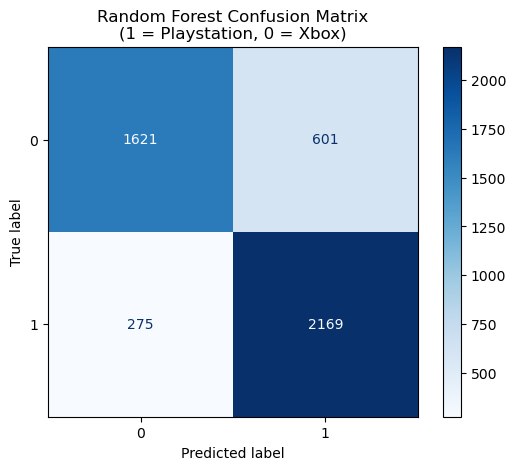

In [149]:
ConfusionMatrixDisplay.from_estimator(gs_rf_cv, X_test, y_test, 
                                      cmap='Blues')

plt.title('Random Forest Confusion Matrix\n(1 = Playstation, 0 = Xbox)');

When viewing the confusion matrix, it looks like the most problematic area for prediction are the false positives, observations that the model thought would be 1/Playstation, but were actually 0/Xbox.  This makes sense given what we saw with the precision and recall scores from the classification report.  I'm most interested in the false positives so I will try and look at some of the text from those observations below.

#### ROC 

We'll plot the ROC AUC for the selected Random Forest model.

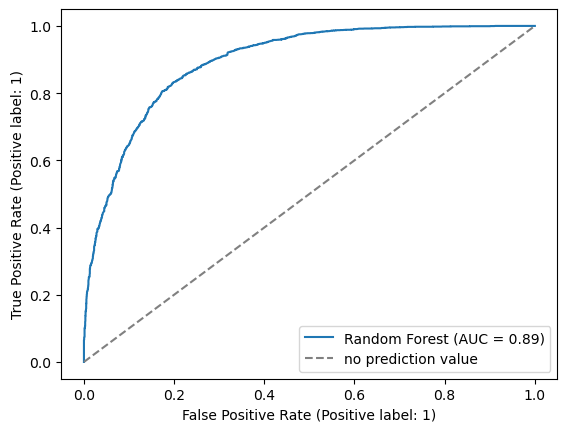

In [150]:
# from a classification lesson
# Create an ax object
ax = plt.gca()

# Use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(gs_rf_cv, X_test, y_test, 
                               ax=ax, name='Random Forest')

# Add 'worst case scenario' line
plt.plot([0,1], [0,1], label='no prediction value', 
         linestyle='--', color='gray')

# Necessary to label the baseline
plt.legend();

This ROC AUC is fairly high (0.89).  In this chart, you are looking at the area above the dotted line, which represents if the model had no prediction value, and under the curved blue line.  The more area under the curve (AUC) the better the model is at discriminating between classes.

#### Specific Classification Examples

I will attempt to look at some of the specific examples, both positive and negative in order to understand any elements that might be contributing to the classification errors.

In [151]:
# make predictions using model
y_preds = gs_rf_cv.predict(X_test)

In [152]:
# get predicted probabilities using model
y_probs = gs_rf_cv.predict_proba(X_test)

In [153]:
# build a dataframe using the information from X_test, y_test, preds, and probs
# https://stackoverflow.com/questions/48947194/add-randomforestclassifier-predict-proba-results-to-original-dataframe

eval_df = pd.DataFrame(X_test)
eval_df['target'] = y_test
eval_df['pred'] = y_preds
eval_df['prob_0'] = y_probs[:,0] 
eval_df['prob_1'] = y_probs[:,1]

In [154]:
eval_df.head()

,text,target,pred,prob_0,prob_1
16782,will not let I buy game normally I would think this be too personal but I remember everyone have issue download last month s game with gold and be wonder if it be maybe a large problem,0,0,0.660000,0.340000
7212,free trial go recently get back into gaming and notice the free trial be not there anyone else,1,1,0.441944,0.558056
1139,which game be you skip on the 4 to play on the 5 for the first time watch dog legion bring this to my attention out in week on 4 or week 5 seem silly to play it on 4 when you could test out your 5 with it,1,1,0.348500,0.651500
16635,be it possible to do the year of gamepass conversion from gold if you ve already do it I buy the gamepass conversion a year ago it expire this week I be wonder if its possible to get a year of gold then buy the gamepass ultimate conversion again to get another year of ultimate I more or less live check to check and can not guarantee I will have that money every month to do it so it be more ...,0,0,0.774500,0.225500
4806,question for 5 backwards compatibility early today ign just release a video talk about how vague the 5 s backward compatibility will be able to work which accord to a statement from ubisoft mean that mainly 4 title will be playable on the while 3 and 2 game will not but now that statement be be redact and it seem like we may only get to play 4 game on the but nothing be be really make offi...,1,1,0.406500,0.593500


Trying to focus in on the false positive records that were prevalent in the confusion matrix.

In [155]:
eval_df[
    (eval_df['target'] == 0) &
    (eval_df['pred'] == 1)
].sort_values(by='prob_1', ascending=False)

,text,target,pred,prob_0,prob_1
11042,another pre order sale do you think that be go to do another pre order sale I hope so so more people can try and get it,0,1,0.237000,0.763000
12224,tell I why any opinion anybody have experience with this game be it worth download I tend to be a fan of story drive game be it similar to the last of we type of game it kind of give I alan wake vibe from look at the trailer,0,1,0.243500,0.756500
18505,I get my account scamme the person delete all of my email and then add there how can I get it back the also change the password,0,1,0.244667,0.755333
11885,any 4k ole 120hz tv recommendation just got pre order time to complete the experience,0,1,0.259834,0.740166
16042,can I get my money back for a pre order that I do not cancel I pre order tannenberg a couple of week ago for £ and I get an email from yesterday say that my pre order have be cancel can I still get my money back,0,1,0.260833,0.739167
...,...,...,...,...,...
16921,how to connect original to computer monitor dvi or vga do some research on my side it seem there be few or no option have anyone have experience do this I would need a converter or some sort to go from a v to the monitor and sound,0,1,0.498500,0.501500
9875,boot help stop ok so basically there ’ this one man in that boot people I know that the new update come out but supposedly there be still a way to boot I be wonder what can be do to stop this and if not I would enjoy to boot he myself with my phone but I know that most be fake any help,0,1,0.498500,0.501500
13265,why do ppl like achievement I be curious what be it about achievement that get people hype,0,1,0.498962,0.501038
9995,why be the cable for the original so unconvential this be a question which have be in the back of my mind for a while but I ve never think to try and research it until now but I can not seem to find any article or answer on google for some reason do anyone know why decide to go with this design,0,1,0.499500,0.500500


It looks like there are multiple observations that are above 70% probability for 1/Playstation, but were actually from the Xbox subreddit.  Let's investigate those a bit more closely.

In [156]:
# show the text of posts that were from the Xbox subreddit, but predicted
# to be from the playstation subreddit with 70% probability or higher
# save in a variable to re-use for the wordcloud

fps = eval_df.loc[eval_df[
        (eval_df['target'] == 0) &
        (eval_df['pred'] == 1) &
        (eval_df['prob_1'] > 0.7)
    ].index].sort_values(by='prob_1', ascending=False)[['text']]

In [157]:
len(fps)

13

In [158]:
fps

,text
11042,another pre order sale do you think that be go to do another pre order sale I hope so so more people can try and get it
12224,tell I why any opinion anybody have experience with this game be it worth download I tend to be a fan of story drive game be it similar to the last of we type of game it kind of give I alan wake vibe from look at the trailer
18505,I get my account scamme the person delete all of my email and then add there how can I get it back the also change the password
11885,any 4k ole 120hz tv recommendation just got pre order time to complete the experience
16042,can I get my money back for a pre order that I do not cancel I pre order tannenberg a couple of week ago for £ and I get an email from yesterday say that my pre order have be cancel can I still get my money back
11817,anyone know why cyberpunk be only usd seem cheap think something be wrong when pre order it
18560,need help contact anyway I can get a call with I ’m have complication at the moment my account got hack and they change everything in a matter of a couple minute even got pass my 2fa but I ’m not worried since I have very recent billing info to prove it be mine but I ’m have more trouble actually get in contact with they
11822,so will store get more stock like tomorrow will I have another chance at preordere again or do I got to wait for release
16127,rock of age unavailable hey guy I notice roa be come out yesterday today and got really hype on the come soon section but now it say unavailable and have be remove from come soon despite release date in the story anybody else have success
10689,really annoying account recovery I have and account that I stop use in it be delete from my and I do not know the email password or phone number for the account all I know be the username I know it seem like it be a stretch but be there anyway to get my account back any info be helpful


There doesn't seem to be any obvious pattern in these posts, although I do see variations of "pre order" and "account" show up fairly often.  But largely, these are posts that I could see being classified as either since they are most related to general order/pre order and account issues.  Both platforms would have accounts and pre-orders, so I can see how the model may have a difficult time classifying these posts.

##### Word Cloud

Let's create word cloud with the 25 most frequent words from the high-percent-probability posts that we were looking at above.

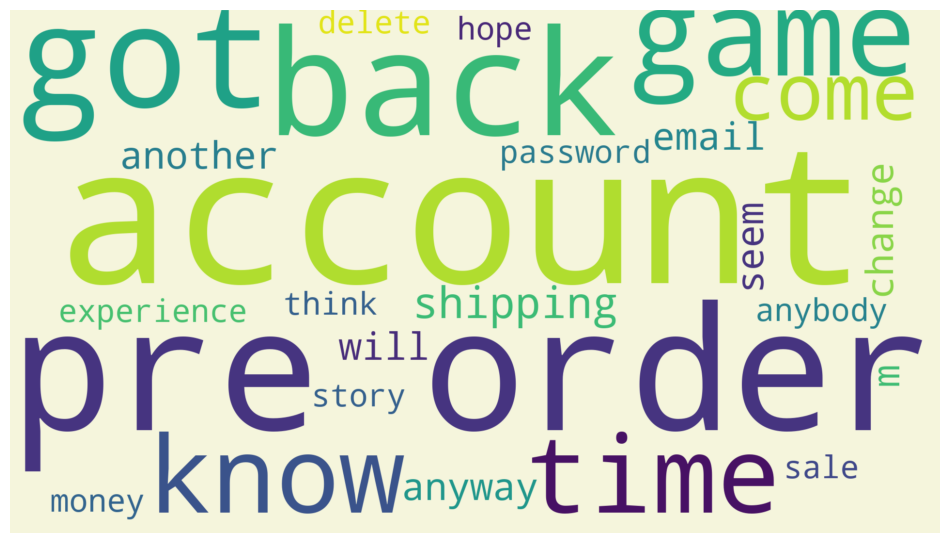

In [163]:
# https://www.python-graph-gallery.com/wordcloud/
# https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe

plt.figure(figsize=(12,8))#

# Create the wordcloud object
wordcloud = WordCloud(width=1920,
                      height=1080,
                      max_words=25,
                      background_color='beige'
                     ).generate(' '.join(fps['text']))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

Looking through this word cloud, there aren't a lot of words that would be specific to Playstation or Xbox, so I can understand that it may have been difficult for the model to distinguish between the classes for these posts.

#### Check Feature Importances

Check the feature importance values to see if there is anything interesting here.  Given the large amount of features that is feeding the model, I'm not expecting to find anything particularly meaningful, but thought it would be worthwhile to see.

In [160]:
# create a dataframe by extracting feature importances and set the index
# to the feature names

feats = pd.DataFrame(
    gs_rf_cv.best_estimator_.named_steps.rf.feature_importances_,
    index=gs_rf_cv.best_estimator_.named_steps.cv.get_feature_names_out())

In [161]:
# rename the column
feats.rename({0: 'importance'}, axis=1, inplace=True)

In [162]:
# get the top 10 features by importance
feats.sort_values(by='importance', ascending=False).head(10)

,importance
series,0.011594
the series,0.005991
one,0.005646
game pass,0.005412
pass,0.004166
be,0.003469
my one,0.003228
the,0.003165
to,0.002927
gold,0.002824


This is where it would be helpful to have domain expertise to see if any of these terms are truly meaningful.  I just did a google search for game pass, and that actually does return what looks to be some subscription service for Xbox, so that is pretty neat that although it wasn't obvious to me that this was related to Microsoft or Xbox that the model did find this and it's an important piece to how the posts are classified.  

It also looks like the current generation of Xbox consoles have "series" in the name, so I can see how that would be important here as well.  Perhaps this accounts for the slighly higher precision score in the classification report for Xbox over Playstation.

## Conclusions and Next Steps

The modeling that was performed improved the accuracy from a 52% baseline accuracy, given the majority class, to 82% accuracy with the chosen Random Forest model after tuning.  This exceeds the 75% target for Kontaku, so they should proceed with the remainder of their analysis.  This proof-of-concept model should give them a good data point to use when performing some additional internal analysis about the cost-benefit of moving towards a more automated and scalable classification and moderation approach.

### Next Steps
For potential next steps relating to this effort, I would put forward:
1. Proceed with cost-benefit analysis
2. Model improvement
    - Look at additional techniques, such as boosting, stacking, and sentiment analysis to see if the model performance can be improved
3. Evaluate the cost of model deployment
    - Having the model is great, but there will be other costs relating to putting this model into production, which should be understood by Kotaku in order to make the best business decision they can## Conclusions and Next Steps